
# сравнение tf-idf и lda в контентном фильтре

In [99]:
import numpy as np
import pandas as pd
import nltk
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
df = pd.read_csv("./steam_games.csv") # https://www.kaggle.com/datasets/trolukovich/steam-games-complete-dataset/data
# df.head(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       40833 non-null  object 
 1   types                     40831 non-null  object 
 2   name                      40817 non-null  object 
 3   desc_snippet              27612 non-null  object 
 4   recent_reviews            2706 non-null   object 
 5   all_reviews               28470 non-null  object 
 6   release_date              37654 non-null  object 
 7   developer                 40490 non-null  object 
 8   publisher                 35733 non-null  object 
 9   popular_tags              37888 non-null  object 
 10  game_details              40313 non-null  object 
 11  languages                 40797 non-null  object 
 12  achievements              12194 non-null  float64
 13  genre                     40395 non-null  object 
 14  game_d

In [16]:
df.head(3)

,url,types,name,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,game_details,languages,achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...","Single-player,Multi-player,Co-op,Steam Achieve...","English,French,Italian,German,Spanish - Spain,...",54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...","Multi-player,Online Multi-Player,Stats","English,Korean,Simplified Chinese,French,Germa...",37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Single-player,Multi-player,Online Multi-Player...","English,French,German,Russian",128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN


In [110]:
df1 = df[["name", "desc_snippet", "game_description", "popular_tags","genre"]]
df2 = pd.DataFrame(df1.fillna(""))[:20000]

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              20000 non-null  object
 1   desc_snippet      20000 non-null  object
 2   game_description  20000 non-null  object
 3   popular_tags      20000 non-null  object
 4   genre             20000 non-null  object
dtypes: object(5)
memory usage: 781.4+ KB


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Дополнительные стоп-слова: https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.json
extensions = ["game", "'ll","'tis","'twas","'ve","10","39","a","a's","able","ableabout","about","above","abroad","abst","accordance","according","accordingly","across","act","actually","ad","added","adj","adopted","ae","af","affected","affecting","affects","after","afterwards","ag","again","against","ago","ah","ahead","ai","ain't","aint","al","all","allow","allows","almost","alone","along","alongside","already","also","although","always","am","amid","amidst","among","amongst","amoungst","amount","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","ao","apart","apparently","appear","appreciate","appropriate","approximately","aq","ar","are","area","areas","aren","aren't","arent","arise","around","arpa","as","aside","ask","asked","asking","asks","associated","at","au","auth","available","aw","away","awfully","az","b","ba","back","backed","backing","backs","backward","backwards","bb","bd","be","became","because","become","becomes","becoming","been","before","beforehand","began","begin","beginning","beginnings","begins","behind","being","beings","believe","below","beside","besides","best","better","between","beyond","bf","bg","bh","bi","big","bill","billion","biol","bj","bm","bn","bo","both","bottom","br","brief","briefly","bs","bt","but","buy","bv","bw","by","bz","c","c'mon","c's","ca","call","came","can","can't","cannot","cant","caption","case","cases","cause","causes","cc","cd","certain","certainly","cf","cg","ch","changes","ci","ck","cl","clear","clearly","click","cm","cmon","cn","co","co.","com","come","comes","computer","con","concerning","consequently","consider","considering","contain","containing","contains","copy","corresponding","could","could've","couldn","couldn't","couldnt","course","cr","cry","cs","cu","currently","cv","cx","cy","cz","d","dare","daren't","darent","date","de","dear","definitely","describe","described","despite","detail","did","didn","didn't","didnt","differ","different","differently","directly","dj","dk","dm","do","does","doesn","doesn't","doesnt","doing","don","don't","done","dont","doubtful","down","downed","downing","downs","downwards","due","during","dz","e","each","early","ec","ed","edu","ee","effect","eg","eh","eight","eighty","either","eleven","else","elsewhere","empty","end","ended","ending","ends","enough","entirely","er","es","especially","et","et-al","etc","even","evenly","ever","evermore","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","face","faces","fact","facts","fairly","far","farther","felt","few","fewer","ff","fi","fifteen","fifth","fifty","fify","fill","find","finds","fire","first","five","fix","fj","fk","fm","fo","followed","following","follows","for","forever","former","formerly","forth","forty","forward","found","four","fr","free","from","front","full","fully","further","furthered","furthering","furthermore","furthers","fx","g","ga","gave","gb","gd","ge","general","generally","get","gets","getting","gf","gg","gh","gi","give","given","gives","giving","gl","gm","gmt","gn","go","goes","going","gone","good","goods","got","gotten","gov","gp","gq","gr","great","greater","greatest","greetings","group","grouped","grouping","groups","gs","gt","gu","gw","gy","h","had","hadn't","hadnt","half","happens","hardly","has","hasn","hasn't","hasnt","have","haven","haven't","havent","having","he","he'd","he'll","he's","hed","hell","hello","help","hence","her","here","here's","hereafter","hereby","herein","heres","hereupon","hers","herself","herse”","hes","hi","hid","high","higher","highest","him","himself","himse”","his","hither","hk","hm","hn","home","homepage","hopefully","how","how'd","how'll","how's","howbeit","however","hr","ht","htm","html","http","hu","hundred","i","i'd","i'll","i'm","i've","i.e.","id","ie","if","ignored","ii","il","ill","im","immediate","immediately","importance","important","in","inasmuch","inc","inc.","indeed","index","indicate","indicated","indicates","information","inner","inside","insofar","instead","int","interest","interested","interesting","interests","into","invention","inward","io","iq","ir","is","isn","isn't","isnt","it","it'd","it'll","it's","itd","itll","its","itself","itse”","ive","j","je","jm","jo","join","jp","just","k","ke","keep","keeps","kept","keys","kg","kh","ki","kind","km","kn","knew","know","known","knows","kp","kr","kw","ky","kz","l","la","large","largely","last","lately","later","latest","latter","latterly","lb","lc","least","length","less","lest","let","let's","lets","li","like","liked","likely","likewise","line","little","lk","ll","long","longer","longest","look","looking","looks","low","lower","lr","ls","lt","ltd","lu","lv","ly","m","ma","made","mainly","make","makes","making","man","many","may","maybe","mayn't","maynt","mc","md","me","mean","means","meantime","meanwhile","member","members","men","merely","mg","mh","microsoft","might","might've","mightn't","mightnt","mil","mill","million","mine","minus","miss","mk","ml","mm","mn","mo","more","moreover","most","mostly","move","mp","mq","mr","mrs","ms","msie","mt","mu","much","mug","must","must've","mustn't","mustnt","mv","mw","mx","my","myself","myse”","mz","n","na","name","namely","nay","nc","nd","ne","near","nearly","necessarily","necessary","need","needed","needing","needn't","neednt","needs","neither","net","netscape","never","neverf","neverless","nevertheless","new","newer","newest","next","nf","ng","ni","nine","ninety","nl","no","no-one","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","notwithstanding","novel","now","nowhere","np","nr","nu","null","number","numbers","nz","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","older","oldest","om","omitted","on","once","one","one's","ones","only","onto","open","opened","opening","opens","opposite","or","ord","order","ordered","ordering","orders","org","other","others","otherwise","ought","oughtn't","oughtnt","our","ours","ourselves","out","outside","over","overall","owing","own","p","pa","page","pages","part","parted","particular","particularly","parting","parts","past","pe","per","perhaps","pf","pg","ph","pk","pl","place","placed","places","please","plus","pm","pmid","pn","point","pointed","pointing","points","poorly","possible","possibly","potentially","pp","pr","predominantly","present","presented","presenting","presents","presumably","previously","primarily","probably","problem","problems","promptly","proud","provided","provides","pt","put","puts","pw","py","q","qa","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","reasonably","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","reserved","respectively","resulted","resulting","results","right","ring","ro","room","rooms","round","ru","run","rw","s","sa","said","same","saw","say","saying","says","sb","sc","sd","se","sec","second","secondly","seconds","section","see","seeing","seem","seemed","seeming","seems","seen","sees","self","selves","sensible","sent","serious","seriously","seven","seventy","several","sg","sh","shall","shan't","shant","she","she'd","she'll","she's","shed","shell","shes","should","should've","shouldn","shouldn't","shouldnt","show","showed","showing","shown","showns","shows","si","side","sides","significant","significantly","similar","similarly","since","sincere","site","six","sixty","sj","sk","sl","slightly","sm","small","smaller","smallest","sn","so","some","somebody","someday","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","sr","st","state","states","still","stop","strongly","su","sub","substantially","successfully","such","sufficiently","suggest","sup","sure","sv","sy","system","sz","t","t's","take","taken","taking","tc","td","tell","ten","tends","test","text","tf","tg","th","than","thank","thanks","thanx","that","that'll","that's","that've","thatll","thats","thatve","the","their","theirs","them","themselves","then","thence","there","there'd","there'll","there're","there's","there've","thereafter","thereby","thered","therefore","therein","therell","thereof","therere","theres","thereto","thereupon","thereve","these","they","they'd","they'll","they're","they've","theyd","theyll","theyre","theyve","thick","thin","thing","things","think","thinks","third","thirty","this","thorough","thoroughly","those","thou","though","thoughh","thought","thoughts","thousand","three","throug","through","throughout","thru","thus","til","till","tip","tis","tj","tk","tm","tn","to","today","together","too","took","top","toward","towards","tp","tr","tried","tries","trillion","truly","try","trying","ts","tt","turn","turned","turning","turns","tv","tw","twas","twelve","twenty","twice","two","tz","u","ua","ug","uk","um","un","under","underneath","undoing","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","upwards","us","use","used","useful","usefully","usefulness","uses","using","usually","uucp","uy","uz","v","va","value","various","vc","ve","versus","very","vg","vi","via","viz","vn","vol","vols","vs","vu","w","want","wanted","wanting","wants","was","wasn","wasn't","wasnt","way","ways","we","we'd","we'll","we're","we've","web","webpage","website","wed","welcome","well","wells","went","were","weren","weren't","werent","weve","wf","what","what'd","what'll","what's","what've","whatever","whatll","whats","whatve","when","when'd","when'll","when's","whence","whenever","where","where'd","where'll","where's","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","whichever","while","whilst","whim","whither","who","who'd","who'll","who's","whod","whoever","whole","wholl","whom","whomever","whos","whose","why","why'd","why'll","why's","widely","width","will","willing","wish","with","within","without","won","won't","wonder","wont","words","work","worked","working","works","world",
              "would","would've","wouldn","wouldn't","wouldnt","ws","www","x","y","ye","year","years","yes","yet","you","you'd","you'll","you're","you've","youd","youll","young","younger","youngest","your","youre","yours","yourself","yourselves","youve","yt","yu","z","za","zero","zm","zr"]


In [31]:
tfidf = TfidfVectorizer(
                     use_idf=True,
                     min_df=0.01,
                     ngram_range=(1,3),
                     stop_words=stopwords
                    )

# объединяем столбики с описаниями, чтобы получить больше информации о каждой игре и обработать тфидф-ом
tfidf_matrix = tfidf.fit_transform(
    df2["popular_tags"] + "\n" + df2["genre"] + df2["desc_snippet"] + "\n" + df2["game_description"]
)

tfidf_matrix.shape

G:\ProgramFiles\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['daren', 'herse', 'himse', 'itse', 'mayn', 'mon', 'myse', 'oughtn'] not in stop_words.
  warnings.warn(


In [130]:
cosine_sim = pairwise_distances(tfidf_matrix, metric='euclidean') #cosine_similarity(tfidf_matrix, tfidf_matrix)


cosine_sim.shape

(20000, 20000)

In [56]:
from sklearn.cluster import KMeans
#k-means
num_clusters = 20
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusterkm = km.labels_.tolist()

In [57]:
import umap.umap_ as umap

embedding = umap.UMAP(n_neighbors=100).fit_transform(tfidf_matrix) # преобразовываем

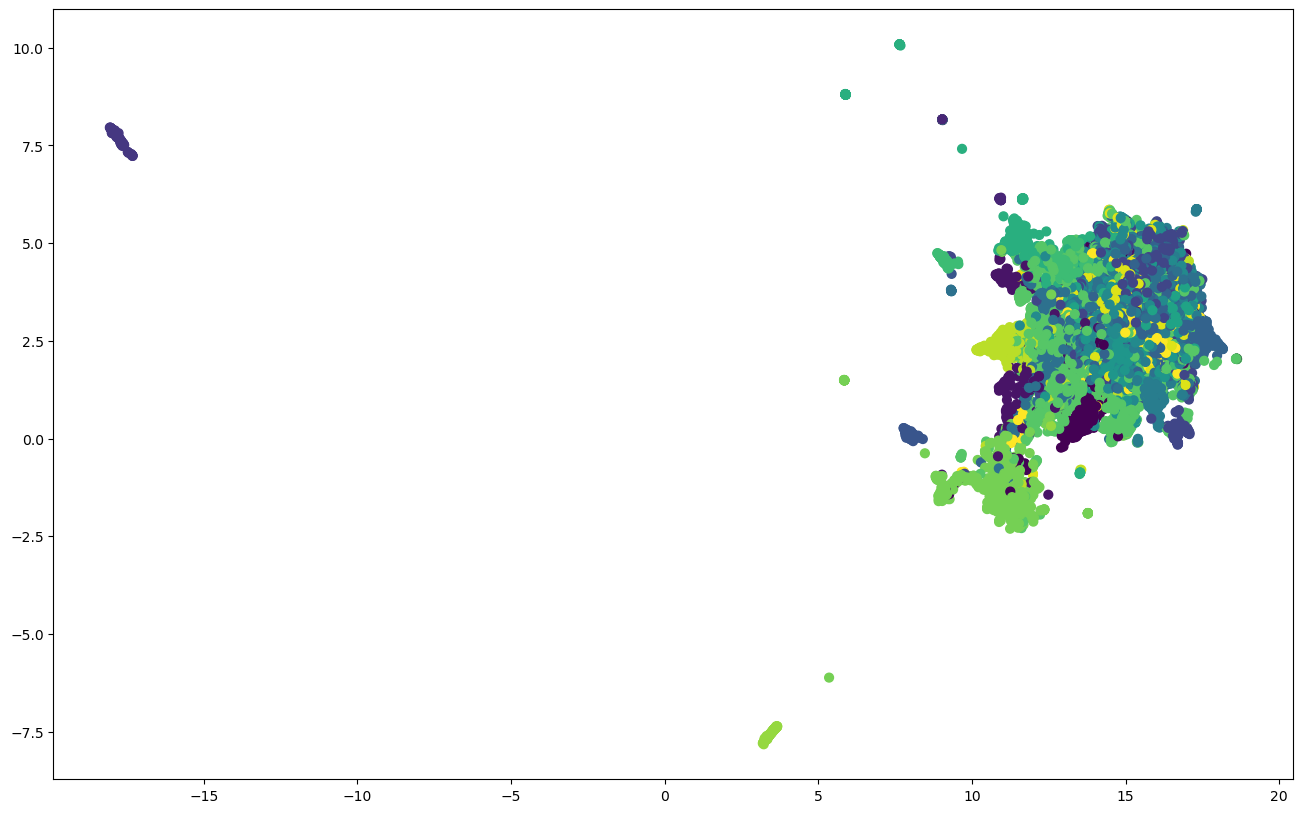

In [58]:
fig, ax = plt.subplots(figsize=(16, 10)) #figsize подбирается под ваш вкус

ax.scatter(embedding[:, 0], embedding[:, 1], s=40, c=clusterkm) #, norm='linear')

plt.show()

In [119]:
def steam_game_recommender(title, cosine_sim, dataframe):
    indices = pd.Series(dataframe.index, index=dataframe['name'])
    indices = indices[~indices.index.duplicated(keep='last')]
    game_index = indices[title]
    similarity_scores = pd.DataFrame(cosine_sim[game_index], columns=["score"])
    game_indices = similarity_scores.sort_values("score", ascending=True)[1:11].index
    return dataframe['name'].iloc[game_indices]

In [39]:
steam_game_recommender("Frostpunk", cosine_sim, df2)

3879                    Holyday City: Reloaded
751                                   Banished
8705                               Hearthlands
6159                                Seasteader
395                           Cities: Skylines
1653                                Anno 2205™
9229    Children of the Nile: Enhanced Edition
159                                 Foundation
2642            Rebuild 3: Gangs of Deadsville
293                             Surviving Mars
Name: name, dtype: object

In [131]:
steam_game_recommender("Frostpunk", cosine_sim, df2)

704                            
15619         IS Defense Editor
13908    BrainBread 2 Mod Tools
7869                           
3879     Holyday City: Reloaded
751                    Banished
8705                Hearthlands
6159                 Seasteader
395            Cities: Skylines
1653                 Anno 2205™
Name: name, dtype: object

In [40]:
steam_game_recommender("EVE Online", cosine_sim, df2)

353                                       Star Trek Online
9321                    Ring of Elysium-Gratitude of Dione
89                                         Ring of Elysium
14814    Steel Ocean - Steam's 1st Anniversary Gift Pac...
1172                                         Star Conflict
15958          Steel Ocean - Thanksgiving Day Gift Package
12996              Realm of the Mad God: Slime Priest Skin
6964                                       DayBreak Online
12533                World of Warships - Indianapolis Pack
158                                          VEGA Conflict
Name: name, dtype: object

In [41]:
steam_game_recommender("DayZ", cosine_sim, df2)

433                 Miscreated
9335    ICY: Frostbite Edition
2263                  CryoFall
871              Mist Survival
4642                  SURVIVAL
517             XERA: Survival
5231        Survival: Last Day
1971              Metro Exodus
290              7 Days to Die
1075           Fade to Silence
Name: name, dtype: object

In [114]:
count_vect = CountVectorizer(stop_words=stopwords,ngram_range=(1,3),min_df=0.01)
dataset = count_vect.fit_transform(
    df2["popular_tags"] + "\n" + df2["genre"] + df2["desc_snippet"] + "\n" + df2["game_description"]
)
dataset.shape

(20000, 1669)

In [75]:
lda = LatentDirichletAllocation(n_components = 60,
                 max_iter=30,
                 n_jobs=6,
                 learning_method='batch',
                 verbose=1)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(max_iter=30, n_components=60, n_jobs=6, verbose=1)

In [115]:
ldamatrix = lda.transform(dataset)
ldamatrix.shape

(20000, 60)

In [137]:
cosine_sim2 = pairwise_distances(ldamatrix, metric='euclidean')

In [117]:
cosine_sim2.shape

(20000, 20000)

In [138]:
steam_game_recommender("DayZ", cosine_sim2, df2)

271                  Left 4 Dead 2
3733    Nether: The Untold Chapter
459                    Watch_Dogs™
517                 XERA: Survival
661                       Unturned
992                    BioShock® 2
1443          State of Decay: YOSE
5696              World of Zombies
816            Plague Inc: Evolved
9515                Darwin Project
Name: name, dtype: object

In [139]:
steam_game_recommender("EVE Online", cosine_sim2, df2)

5751                                           Exocraft
353                                    Star Trek Online
9191     Of Guards And Thieves - Permanent Gold Account
2405                                             Airmen
19784                  Trove - Arcanium Expedition Pack
19744                            TERA: Accessorize Pack
1890                        CardLife: Creative Survival
3337                                      Mortal Online
4737                                          Hero Zero
2257                            Age of Conan: Unchained
Name: name, dtype: object

In [140]:
steam_game_recommender("Frostpunk", cosine_sim2, df2)

1493                      Medieval Engineers
1165                               Citystate
751                                 Banished
732     Workers & Resources: Soviet Republic
2421                              Anno 2070™
242                              Dawn of Man
2642          Rebuild 3: Gangs of Deadsville
1071                        Project Highrise
2266                                Mashinky
3870             Crest - an indirect god sim
Name: name, dtype: object

In [127]:
metrics = ['cosine', 'euclidean']
train_data = df2["popular_tags"] + "\n" + df2["genre"] + df2["desc_snippet"] + "\n" + df2["game_description"]

In [126]:
for metr in metrics:
    start_time = time.time()

    tfidf_time = TfidfVectorizer(use_idf=True, min_df=0.01, ngram_range=(1,3), stop_words=stopwords)
    # объединяем столбики с описаниями, чтобы получить больше информации о каждой игре и обработать тфидф-ом
    tfidf_matrix_time = tfidf.fit_transform(train_data)
    cosine_sim_time = pairwise_distances(tfidf_matrix, metric=metr) #cosine_similarity(tfidf_matrix, tfidf_matrix)

    end_time = time.time()
    e_time = (end_time - start_time)
    print("Время на инициализацию tf-idf с метрикой {}: {} c".format(metr, e_time))

Время на инициализацию tf-idf с метрикой cosine: 28.351462602615356 c
Время на инициализацию tf-idf с метрикой euclidean: 23.819862604141235 c


TypeError: scipy distance metrics do not support sparse matrices.

In [128]:
for metr in metrics:
    start_time = time.time()
    
    count_vect_time = CountVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=0.01)
    dataset_time_time = count_vect.fit_transform(train_data)
    lda_time = LatentDirichletAllocation(n_components = 60,max_iter=30,n_jobs=6,learning_method='batch')
    ldamatrix_time = lda.fit_transform(dataset)
    cosine_sim2_time = pairwise_distances(ldamatrix, metric=metr)

    end_time = time.time()
    e_time = (end_time - start_time)
    print("Время на инициализацию tf-idf с метрикой {}: {} c".format(metr, e_time))

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
Время на инициализацию tf-idf с метрикой cosine: 110.9689519405365 c
iteration: 1 of max_iter: 30
iteration: 